In [3]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.linear_model import Ridge, SGDRegressor
from scipy.linalg import LinAlgWarning

import warnings
warnings.filterwarnings(action='ignore', category=LinAlgWarning, module='sklearn')

INPUT_FIELDS = [
    'CRITICALITY',
    'CONNECTIVITY',
    'RELIABILITY',
    'IMPORTANCE',
    'PROVIDED_INTERFACE',
    'REQUIRED_INTERFACE',
    'ADT',
    ' PMax',
    'alpha',
    'In Use REPLICA',
    'LOAD',
]
OUTPUT_FIELD = 'OPTIMAL_UTILITY'

data = pd.read_csv('../data/Traning_mRubis_Batch_2.csv').dropna(subset=['Shop'])[INPUT_FIELDS + [OUTPUT_FIELD]]
data['beta'] = data.apply(lambda row: row['PROVIDED_INTERFACE'] + (0 if row['PROVIDED_INTERFACE'] >= 2 else 1), axis=1)

data['Linear'] = data['RELIABILITY'] * data['CRITICALITY'] * (data['PROVIDED_INTERFACE'] + data['REQUIRED_INTERFACE'])
data['Saturating'] = data['RELIABILITY'] * \
                    data['CRITICALITY'] * \
                    data[' PMax'] * \
                    np.tanh(data['alpha'] * \
                    data['In Use REPLICA'] / data['LOAD']) * \
                    (data['PROVIDED_INTERFACE'] + data['REQUIRED_INTERFACE'])
data['Discontinuous'] = data['RELIABILITY'] * data['CRITICALITY'] * (data['REQUIRED_INTERFACE'] + 1) * data['IMPORTANCE'] * data['beta'] * data['PROVIDED_INTERFACE'] - 10 * data['ADT']
data['Combined'] = data['RELIABILITY'] * data['CRITICALITY'] * data['IMPORTANCE'] * data['beta'] * data[' PMax'] * np.tanh(data['alpha'] * data['In Use REPLICA'] / data['LOAD']) *  (data['REQUIRED_INTERFACE'] + 1) - 10 * data['ADT']
data

,CRITICALITY,CONNECTIVITY,RELIABILITY,IMPORTANCE,PROVIDED_INTERFACE,REQUIRED_INTERFACE,ADT,PMax,alpha,In Use REPLICA,LOAD,OPTIMAL_UTILITY,beta,Linear,Saturating,Discontinuous,Combined
0,13.0,2,0.50,22.0,1,1,1.009460,12.800424,79.380799,12.0,221.0,7306.332791,2.0,13.0,166.345500,5.619054e+02,7309.107418
1,30.0,5,0.85,22.0,4,1,1.211251,15.031340,79.542106,12.0,229.0,67448.539269,4.0,127.5,1915.577396,1.793989e+04,67416.211819
2,30.0,4,0.50,22.0,0,4,1.460128,12.903071,167.792201,11.0,434.0,21275.465917,1.0,60.0,773.871039,-1.460128e+01,21266.852292
3,24.0,2,0.50,22.0,1,1,1.175642,5.323259,154.197090,7.0,119.0,5609.603276,2.0,24.0,127.758217,1.044244e+03,5609.605113
4,25.0,4,0.50,22.0,0,4,1.077155,13.448238,126.901175,12.0,373.0,18480.555313,1.0,50.0,672.029563,-1.077155e+01,18470.041427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,12.0,16,0.50,22.0,15,1,1.160442,5.886177,77.141379,14.0,468.0,22968.115150,15.0,96.0,553.995034,5.938840e+04,22840.690744
599,27.0,134,0.50,22.0,133,1,1.101619,6.164631,85.670351,10.0,169.0,486968.698456,133.0,1809.0,11150.936733,1.050725e+07,486968.698456
600,27.0,5,0.50,22.0,0,5,1.356134,8.060657,73.959463,15.0,449.0,14146.777514,1.0,67.5,536.376472,-1.356134e+01,14146.777514
601,16.0,14,0.50,22.0,13,1,1.267240,16.466418,88.501706,6.0,92.0,75336.196933,13.0,112.0,1844.203095,5.947533e+04,75336.196933


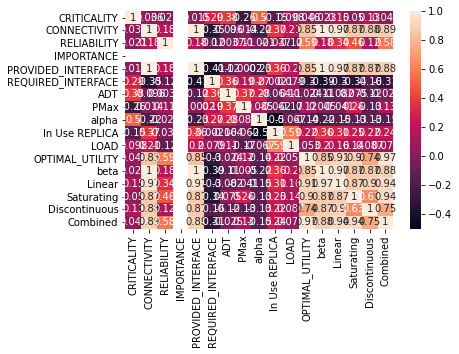

In [4]:
sn.heatmap(data.corr(), annot=True)
None

In [5]:
# # NaNs are dropped here, because 'Saturating' might be NaN for rows with 'LOAD' == 0.0
# data_cleaned = data.fillna({'Saturating': 0.0})

# 'IMPORTANCE' is dropped, because it is constant throughout the dataset
# 'CONNECTIVITY' is dropped, because it is perfectly correlated with 'PROVIDED_INTERFACE' and 'beta'
# 'REQUIRED_INTERFACE' is dropped, because it is perfectly correlated with 'beta'
X = data[INPUT_FIELDS + ['beta', 'Linear', 'Saturating', 'Discontinuous', 'Combined']].drop(['IMPORTANCE', 'CONNECTIVITY', 'REQUIRED_INTERFACE'], axis=1)
y = data[OUTPUT_FIELD]

In [6]:
def run_ridge(features, y, normalize=False):
    errors = []
    parameters = []
    for train_index, test_index in LeaveOneOut().split(features, y):
        X_train, X_test = features.values[train_index], features.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        ridge = Ridge(normalize)
        ridge.fit(X_train, y_train)
        errors.append(ridge.predict(X_test) - y_test)
        parameters.append(ridge.coef_)
    print(
        f'Mean Squared Error = {np.average(np.square(errors)):0.2f}'
    )
    plt.barh(features.columns, pd.DataFrame(parameters).sum())
    plt.show()

Mean Squared Error = 1483524470.00


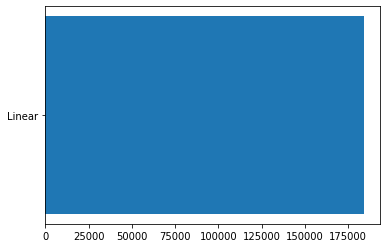

In [9]:
# Only Linear
run_ridge(X[['Linear']], y)

Mean Squared Error = 1642407421.29


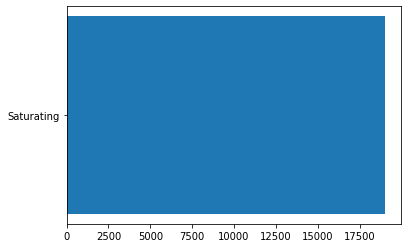

In [10]:
# Only Saturating
run_ridge(X[['Saturating']], y)

Mean Squared Error = 3901204125.70


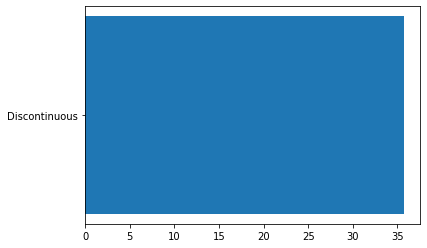

In [11]:
# Only Discontinuous
run_ridge(X[['Discontinuous']], y)

Mean Squared Error = 428445356.60


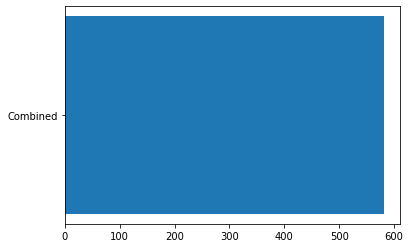

In [12]:
# Only Combined
run_ridge(X[['Combined']], y)

Mean Squared Error = 597753352.06


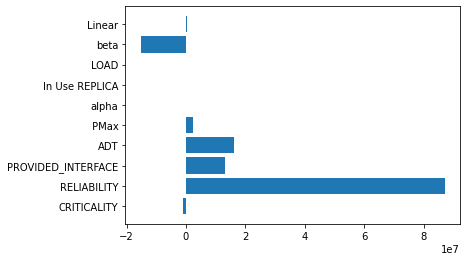

In [13]:
# Base features with Linear
run_ridge(X.drop(['Saturating', 'Discontinuous', 'Combined'], axis=1), y, normalize=True)

Mean Squared Error = 679020253.64


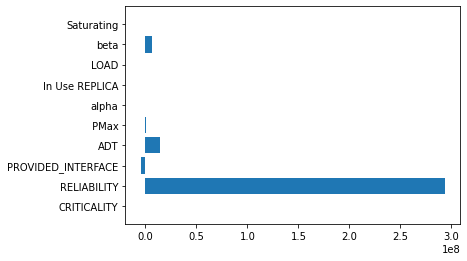

In [14]:
# Base features with Saturating
run_ridge(X.drop(['Linear', 'Discontinuous', 'Combined'], axis=1), y)

Mean Squared Error = 667797329.32


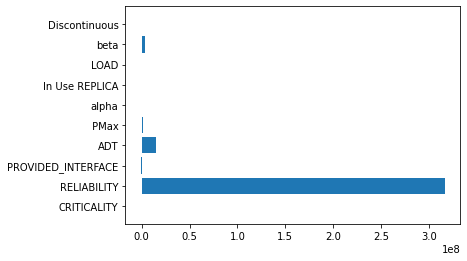

In [15]:
# Base features with Discontinuous
run_ridge(X.drop(['Linear', 'Saturating', 'Combined'], axis=1), y)

Mean Squared Error = 425821737.90


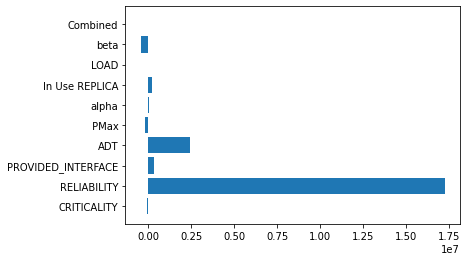

In [16]:
# Base features with Combined
run_ridge(X.drop(['Linear', 'Saturating', 'Discontinuous'], axis=1), y)

Mean Squared Error = 434573828.86


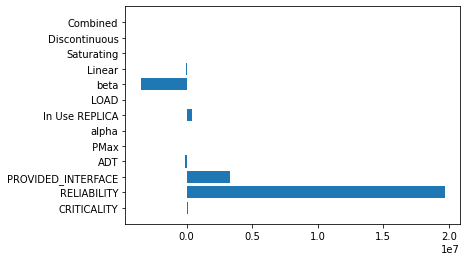

In [18]:
# All features
run_ridge(X, y)

In [19]:
def run_ridge_offline(features):
    scaler = StandardScaler()
    scaler.fit(features)
    features_scaled = scaler.transform(features)
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, y, test_size=0.1, random_state=42)
    ridge = SGDRegressor(loss='squared_loss', penalty='l2')
    ridge.fit(X_train, y_train)
    score = ridge.score(X_test, y_test)
    print(score)
run_ridge_offline(X.drop(['Linear', 'Saturating', 'Discontinuous','Combined'], axis=1))
run_ridge_offline(X.drop(['Saturating', 'Discontinuous','Combined'], axis=1))
run_ridge_offline(X[['Combined']])

0.9730593613989535
0.9811643443766178
0.9929441915052666


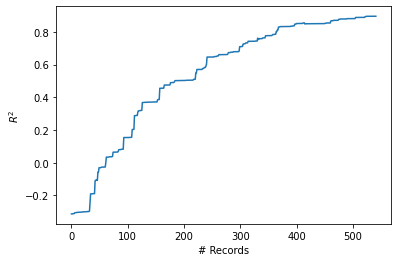

In [43]:
def run_ridge_online(features, y):
    scaler = StandardScaler()
    scaler.fit(features)
    features_scaled = scaler.transform(features)
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, y, test_size=0.1, random_state=42)
    ridge = SGDRegressor(loss='squared_loss', penalty='l2')
    x = []
    scores = []
    for i, row in enumerate(X_train):
        ridge.partial_fit(row.reshape(1, -1), np.asarray([y_train.to_numpy()[i]]))
        scores.append(ridge.score(X_test, y_test))
        x.append(i)
    sn.lineplot(x=x, y=scores)
    plt.xlabel("# Records")
    plt.ylabel("$R^2$")
run_ridge_online(X[['Combined']], y)
plt.savefig('online.png', dpi=300, facecolor='white', edgecolor='none')

# Nonstationarity
## Idea 1: Assuming a linear drift
- Add time to the set of features
- Let linear regression learn the parameter for the drift (shift/time)

## Idea 2: Assuming some kind of drift or seasonality
- Stationarize time series using Difference Transform (https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/)
- https://pypi.org/project/stationarizer/

## Idea 3: No assumptions about the nature of the nonstationarity
- Train initial model, measure R^2 on test set
- Monitor R^2 for all observations that were added later
- If R^2 becomes too low, train a new model using the most recent observations, monitor R^2 for all observations that were added later


In [1]:
def load_data(path):
    data = pd.read_csv(path).dropna(subset=['Shop'])[INPUT_FIELDS + [OUTPUT_FIELD]]
    data['beta'] = data.apply(lambda row: row['PROVIDED_INTERFACE'] + (0 if row['PROVIDED_INTERFACE'] >= 2 else 1), axis=1)

    data['Linear'] = data['RELIABILITY'] * data['CRITICALITY'] * (data['PROVIDED_INTERFACE'] + data['REQUIRED_INTERFACE'])
    data['Saturating'] = data['RELIABILITY'] * \
                        data['CRITICALITY'] * \
                        data[' PMax'] * \
                        np.tanh(data['alpha'] * \
                        data['In Use REPLICA'] / data['LOAD']) * \
                        (data['PROVIDED_INTERFACE'] + data['REQUIRED_INTERFACE'])
    data['Discontinuous'] = data['RELIABILITY'] * data['CRITICALITY'] * (data['REQUIRED_INTERFACE'] + 1) * data['IMPORTANCE'] * data['beta'] * data['PROVIDED_INTERFACE'] - 10 * data['ADT']
    data['Combined'] = data['RELIABILITY'] * data['CRITICALITY'] * data['IMPORTANCE'] * data['beta'] * data[' PMax'] * np.tanh(data['alpha'] * data['In Use REPLICA'] / data['LOAD']) *  (data['REQUIRED_INTERFACE'] + 1) - 10 * data['ADT']
    return data

In [29]:
data_nonstationary = load_data('../data/TrainingmRUBiS_Theta0.01_NonStationary.csv')

In [30]:
data_nonstationary

,CRITICALITY,CONNECTIVITY,RELIABILITY,IMPORTANCE,PROVIDED_INTERFACE,REQUIRED_INTERFACE,ADT,PMax,alpha,In Use REPLICA,LOAD,OPTIMAL_UTILITY,beta,Linear,Saturating,Discontinuous,Combined
0,16.0,2,0.5,22.0,1,1,1.267240,16.466418,88.501706,4.0,73.0,28834.135762,2.0,16.0,263.430367,691.327604,11578.263731
1,16.0,2,0.5,22.0,1,1,1.267240,16.466418,88.501706,4.0,73.0,28720.906146,2.0,16.0,263.430367,691.327604,11578.263731
2,30.0,5,0.9,22.0,4,1,1.211251,15.031340,79.542106,12.0,229.0,171918.388147,4.0,135.0,2028.258419,18995.887487,71382.583838
3,23.0,2,0.5,22.0,1,1,1.055559,5.798189,73.839639,6.0,95.0,14583.798934,2.0,23.0,133.334627,1001.444413,5856.167991
4,13.0,3,0.5,22.0,2,1,1.009460,12.800424,79.380799,12.0,234.0,18206.999793,2.0,19.5,249.462963,1133.905396,7307.485632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,20.0,13,0.5,22.0,12,1,1.006633,9.717122,137.960688,4.0,109.0,61250.707235,12.0,130.0,1263.124653,63349.933666,51292.227281
1019,23.0,24,0.5,22.0,23,1,1.110298,5.972367,77.342989,4.0,67.0,76265.563429,23.0,276.0,1648.051759,267662.897018,69481.746208
1020,20.0,13,0.5,22.0,12,1,1.006633,9.717122,137.960688,4.0,109.0,61175.404966,12.0,130.0,1263.124653,63349.933666,51292.227281
1021,23.0,24,0.5,22.0,23,1,1.110298,5.972367,77.342989,4.0,93.0,75321.332500,23.0,276.0,1644.126254,267662.897018,69316.220723


<AxesSubplot:xlabel='Combined', ylabel='OPTIMAL_UTILITY'>

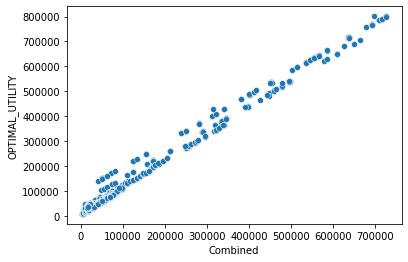

In [18]:
sn.scatterplot(x='Combined', y='OPTIMAL_UTILITY', data=data_nonstationary)

<AxesSubplot:xlabel='Combined', ylabel='OPTIMAL_UTILITY'>

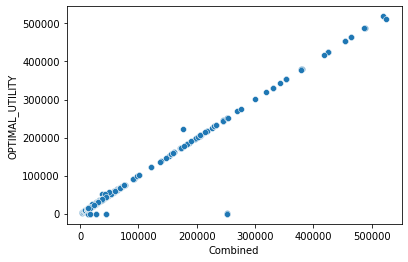

In [19]:
sn.scatterplot(x='Combined', y='OPTIMAL_UTILITY', data=data)

In [20]:
X_nonstationary = data_nonstationary[INPUT_FIELDS + ['beta', 'Linear', 'Saturating', 'Discontinuous', 'Combined']].drop(['IMPORTANCE', 'CONNECTIVITY', 'REQUIRED_INTERFACE'], axis=1)
y_nonstationary = data_nonstationary[OUTPUT_FIELD]

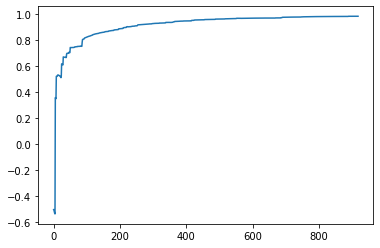

In [28]:
run_ridge_online(X_nonstationary, y_nonstationary)

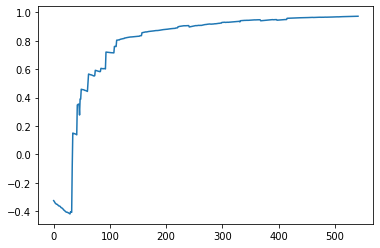

In [27]:
run_ridge_online(X, y)